# M54 data 

Four our test with real data, we will use the globular cluster M54. Benefit of this object is that we have a good estimate of the ground truth. A comparison between the (age,metallicity) distributions from MAP estimates (using the PPXF software) and the ground truth is presented in [Boecker et al](https://ui.adsabs.harvard.edu/abs/2020ApJ...896...13B/abstract) (who also kindly provided this data).

The code has been updated to read in this data. Before running this, you will need:
1. `pip install spectres`
2. get the appropriate SSP models. To do this:
   - go to the [MILES site](http://research.iac.es/proyecto/miles/pages/webtools/tune-ssp-models.php)
   - in the 'Input parameters' section, choose 'E-MILES' in the drop down menu under 'SSP Models'
   - leave all other settings as default
   - click 'Submit Query'
   - a new page opens. Follow the link to the 'MILES FTP'
   - this should open a folder with several tarred data files. You want `EMILES_BASTI_BASE_BI_FITS.tar.gz`
   - unzip this into the location `uq4pk/data/EMILES_BASTI_BASE_BI_FITS`. This should contain 8904 files with names like `Ebi3.50Zp0.40T14.0000_iTp0.00_baseFe.fits`

## Look at the data

In [1]:
cd ../

/Users/pjethwa/Astro/Science/uq4pk


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src

m54_data = uq4pk_src.data.M54()
print(m54_data.y.shape)

m54_data.logarithmically_resample(dv=50.)
print(m54_data.y.shape)

(3361,)

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

(3800,)


The M54 data consists of a observed spectrum, noise level, and a mask. The regions with `mask==0` should be excluded from the fit as they are contaminated with sky spectra.

Text(0, 0.5, 'Mask [0=exclude]')

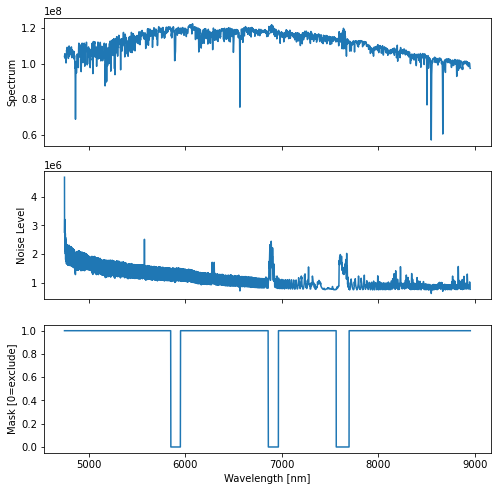

In [3]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax[0].plot(m54_data.lmd, m54_data.y)
ax[1].plot(m54_data.lmd, m54_data.noise_level)
ax[2].plot(m54_data.lmd, m54_data.mask)

ax[2].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Spectrum')
ax[1].set_ylabel('Noise Level')
ax[2].set_ylabel('Mask [0=exclude]')

Additionally, we have estimates of age/metallicity distributiuons:

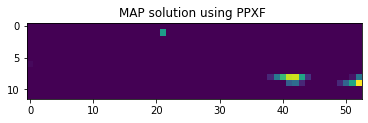

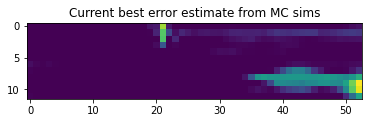

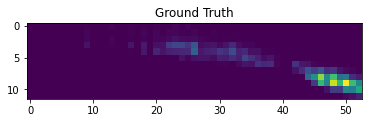

In [4]:
def orient_image(img):
    return np.flipud(img.T)

# MAP solutuon
img = m54_data.ppxf_map_solution
plt.imshow(orient_image(img))
plt.gca().set_title('MAP solution using PPXF ')
plt.show()

# current best error estimate
# 100 MAP solutions from monte carlo resampling of noise
img = np.std(m54_data.mcsims_map_weights, -1)
plt.imshow(orient_image(img))
plt.gca().set_title('Current best error estimate from MC sims')
plt.show()

# ground truth 
img = m54_data.ground_truth
plt.imshow(orient_image(img))
plt.gca().set_title('Ground Truth')
plt.show()

## SSP models

*Note*: the SSP models we need to fit this data are different to those we have been using previously (due to different wavelength ranges). To get the right models, follow the instructions above to get the data-files, which should then be read in as follows,

In [5]:
ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light

## Evaluating the observation operator

In [6]:
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(ssps=ssps,
                        dv=ssps.dv,
                        do_log_resample=False)

Distribution functions should have shape (12, 53)


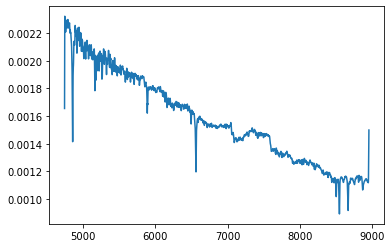

In [7]:
# example input parametrs
f = np.abs(np.random.uniform(size=(12,53)))
Theta_v = [50, 100, 1, 0, 0, 0.3, 0.1]

ybar = G.evaluate(f, Theta_v)

plt.plot(ssps.lmd, ybar, '-')

The jump seen at the start and end of this model spectrum are artifacts of performing a convolution using fourier transforms (which incorrectly assumes that the LOSVD is periodic).

To counter this, we can add the first and last pixels to the data mask,

In [8]:
npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask] = False